In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import my_functions as my_func
import matplotlib.pyplot as plt

from petTOAD_load import *
from scipy.stats import spearmanr

def choose_limits(list_values):
    v1 = np.abs(min(list_values))
    v2 = np.abs(max(list_values))
    if v1 > v2:
        return v1
    else:
        return v2
    
def get_list_corr(fc_node_avg, disconn):
    list_r = []
    list_p = []
    for i in range(fc_node_avg.shape[1]):
        r, p = spearmanr(fc_node_avg[:, i], disconn[:, i])
        list_r.append(r)
        list_p.append(p)
    return np.array(list_r), np.array(list_p)


def plot_corr_fc_avg_disconn_axs(ax, corr_node_avg_disconn_r, corr_node_avg_disconn_p):
    i_p = 0
    i_no_p = 0
    for i, corr in enumerate(corr_node_avg_disconn_r):
        if corr_node_avg_disconn_p[i] < 0.05:
            ax.barh(i, corr, color="tab:green", label="p < 0.05" if i_p == 0 else "")
            i_p +=1
        else:
            ax.barh(i, corr, color="tab:blue", label="p >= 0.05" if i_no_p == 0 else "")
            i_no_p +=1

def calculate_fc_wmh_bin(df, group):
    list_fc = []

    for subj in df[df["Group_bin_Fazekas"] == group]["PTID"]:
        ts_subj = load_ts_aal(subj)
        fc = my_func.fc(ts_subj)
        list_fc.append(fc)
    arr_fc = np.array(list_fc)
    return arr_fc

def calculate_disconn_wmh_bin(df, group):
    list_disconn = []

    for subj in df[df["Group_bin_Fazekas"] == group]["PTID"]:
        disconn_subj = get_node_damage(subj, is_random = False)
        list_disconn.append(disconn_subj)
    arr_disconn = np.array(list_disconn)
    return arr_disconn

In [3]:
# Load the subjects df
df_petTOAD_pre = pd.read_csv(RES_DIR / "df_petTOAD.csv", index_col = 0)
df_petTOAD_pre["WMH_bin"] = np.where(
    df_petTOAD_pre["Group_bin_Fazekas"].str.contains("no_WMH"), "no_WMH", "WMH"
)
df_petTOAD = df_petTOAD_pre.copy()

In [4]:
fc_str_cn_wmh = calculate_fc_wmh_bin(df_petTOAD, "CN_WMH").mean(axis=2)
fc_str_mci_wmh = calculate_fc_wmh_bin(df_petTOAD, "MCI_WMH").mean(axis=2)
fc_str_wmh = np.concatenate([fc_str_cn_wmh, fc_str_mci_wmh])

In [5]:
disconn_cn_wmh = calculate_disconn_wmh_bin(df_petTOAD, "CN_WMH")
disconn_mci_wmh = calculate_disconn_wmh_bin(df_petTOAD, "MCI_WMH")
disconn_wmh = np.concatenate([disconn_cn_wmh, disconn_mci_wmh])

/home/leoner/miniconda3/envs/neurolib/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


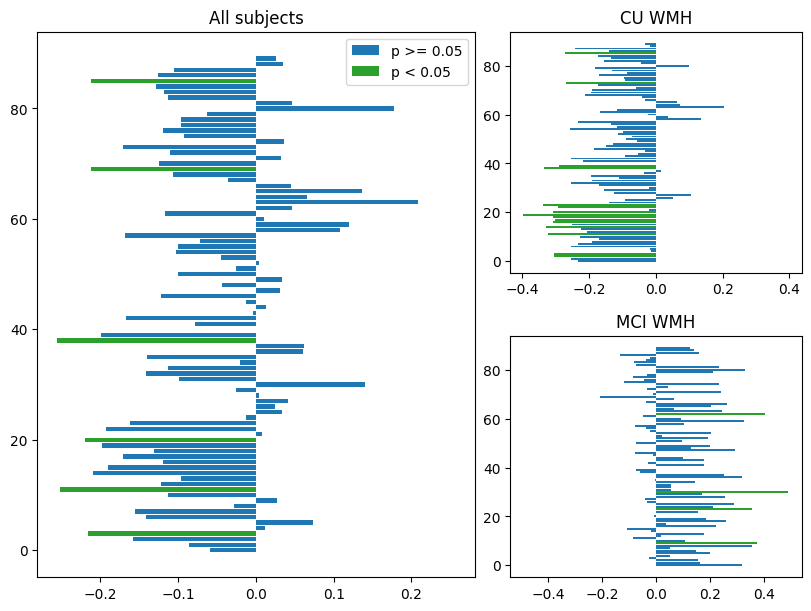

In [6]:
corr_fc_str_disconn_r_wmh, corr_fc_str_disconn_p_wmh = get_list_corr(fc_str_wmh, disconn_wmh)
corr_fc_str_disconn_r_cn_wmh, corr_fc_str_disconn_p_cn_wmh = get_list_corr(fc_str_cn_wmh, disconn_cn_wmh)
corr_fc_str_disconn_r_mci_wmh, corr_fc_str_disconn_p_mci_wmh = get_list_corr(fc_str_mci_wmh, disconn_mci_wmh)

lim_barplot_all_wmh = choose_limits(corr_fc_str_disconn_r_wmh)
lim_barplot_cn_wmh = choose_limits(corr_fc_str_disconn_r_cn_wmh)
lim_barplot_mci_wmh = choose_limits(corr_fc_str_disconn_r_mci_wmh)

fig = plt.figure(figsize=(8, 6), constrained_layout=True)
axs = fig.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1.5, 1]})
axs['Left'].set_title('All subjects')
axs['TopRight'].set_title('CU WMH')
axs['BottomRight'].set_title('MCI WMH')

plot_corr_fc_avg_disconn_axs(axs["Left"], corr_fc_str_disconn_r_wmh, corr_fc_str_disconn_p_wmh)
plot_corr_fc_avg_disconn_axs(axs["TopRight"], corr_fc_str_disconn_r_cn_wmh, corr_fc_str_disconn_p_cn_wmh)
plot_corr_fc_avg_disconn_axs(axs["BottomRight"], corr_fc_str_disconn_r_mci_wmh, corr_fc_str_disconn_p_mci_wmh)

axs["Left"].set_xlim(-lim_barplot_all_wmh - lim_barplot_all_wmh/10, lim_barplot_all_wmh + lim_barplot_all_wmh/10)
axs["TopRight"].set_xlim(-lim_barplot_cn_wmh - lim_barplot_cn_wmh/10, lim_barplot_cn_wmh + lim_barplot_cn_wmh/10)
axs["BottomRight"].set_xlim(-lim_barplot_mci_wmh - lim_barplot_mci_wmh/10, lim_barplot_mci_wmh + lim_barplot_mci_wmh/10)
axs["Left"].legend()

In [7]:
from plotting_utils import *

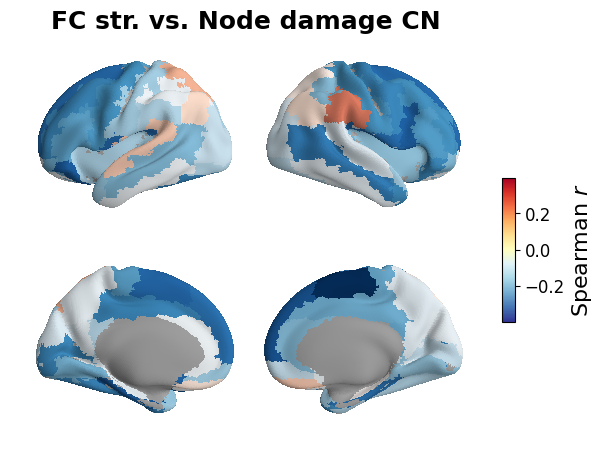

In [17]:
img_fc_str_cn_wmh = plot_surface_reconstruction_vector("corr_fc_str_disconn_cn_wmh", corr_fc_str_disconn_r_cn_wmh, "FC str. vs. node damage CN", r"Spearman $r$")

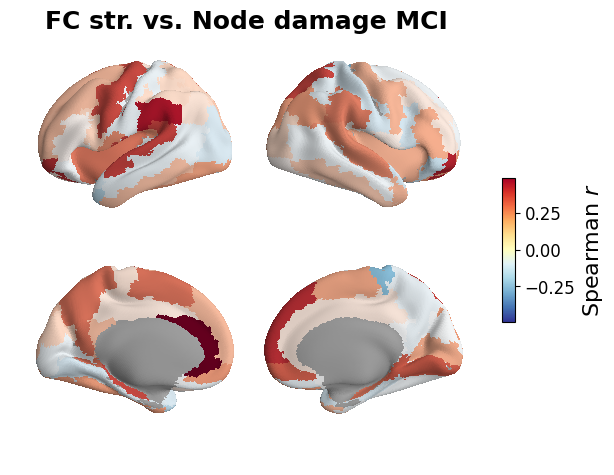

In [18]:
img_fc_str_mci_wmh = plot_surface_reconstruction_vector("corr_fc_str_disconn_mci_wmh", corr_fc_str_disconn_r_mci_wmh, "FC str. vs. Node damage MCI", r"Spearman $r$")

0.45572298266442895